# Stability Analysis & Variational Bayesian Gaussian Mixture

In this notebook, the stability of the Callaham proposed method is tested, by comparing the results obtained when setting multiple number of clusters when initialising the model.

First, the same preprocessing is done, as in the ```Boundary_Layer``` Notebook.

In [30]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
import matplotlib as mpl
from matplotlib.colors import ListedColormap

# adding Tools to the system path
sys.path.insert(0, "../Tools/")
import plot_funcs as pf  # noqa: E402
import stability_assessment as sa  # noqa: E402
import preprocessing as pp  # noqa: E402

# Set the plotting style
mpl.rc("text", usetex=True)
mpl.rc("font", family="serif")
mpl.rc("figure", figsize=(15, 3))
mpl.rc("xtick", labelsize=14)
mpl.rc("ytick", labelsize=14)
mpl.rc("axes", labelsize=20)
mpl.rc("axes", titlesize=20)

# Set the colormap
cm = sns.color_palette("tab10").as_hex()
cm.insert(0, "#ffffff")
cm = ListedColormap(cm)
cm.set_bad("darkgrey")

In [31]:
# Create plot directory if it doesn't exist yet
cur_dir = os.getcwd()
proj_dir = os.path.dirname(cur_dir)
plots_dir = os.path.join(proj_dir, "Plots/Stab_Ass")
os.makedirs(plots_dir, exist_ok=True)

# 1. Preprocessing

## a. Load the data

In [32]:
# Load the data from http://turbulence.pha.jhu.edu/Transition_bl.aspx
file = h5py.File("../Data/Transition_BL_Time_Averaged_Profiles.h5", "r")

In [33]:
# Get arrays for variables and the Reynold's averages
x = np.array(file["x_coor"])
y = np.array(file["y_coor"])
u_bar = np.array(file["um"])
v_bar = np.array(file["vm"])
p_bar = np.array(file["pm"])
R_uu = np.array(file["uum"]) - u_bar**2
R_uv = np.array(file["uvm"]) - u_bar * v_bar

In [34]:
# Visualize by wall-normal Reynolds stress
X, Y = np.meshgrid(x, y)

# Include line of 99% of free flow mean velocity
# Values from http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf
U_inf = 1
nu = 1 / 800
Re = (U_inf / nu) * x

## b. Get the finite difference derivatives to estimate the gradients

__NOTE: VARIABLE STEP SIZE IN Y DIRECTION ONLY__

In [35]:
# Get x space step
dx = x[1] - x[0]
# Number of points in x and y
nx = len(x)
ny = len(y)

# Get y space steps:
# The y step is not constant, so we need to calculate it for each point
dy = np.diff(y[::-1])
dy = np.append(dy, dy[-1])

# Get the gradients
u_x, u_y, lap_u, v_y, p_x, R_uux, R_uvy = pp.get_derivatives_numpy(
    nx, ny, dx, y, u_bar, v_bar, p_bar, R_uu, R_uv
)

# Flatten arrays using fortran ordering
u_bar = u_bar.flatten("F")
v_bar = v_bar.flatten("F")
p_bar = p_bar.flatten("F")
R_uu = R_uu.flatten("F")
R_uv = R_uv.flatten("F")
lap_u = lap_u.flatten("F")
R_uux = R_uux.flatten("F")
R_uvy = R_uvy.flatten("F")
u_x = u_x.flatten("F")
u_y = u_y.flatten("F")
v_y = v_y.flatten("F")
p_x = p_x.flatten("F")

## c. Equation space representation

In [36]:
# Labels of terms in the RANS equation
labels = [
    r"$\bar{u} \bar{u}_x$",
    r"$\bar{v}\bar{u}_y$",
    r"$\rho^{-1} \bar{p}_x$",
    r"$\nu \nabla^2 \bar{u}$",
    r"$\overline{(u^\prime v^\prime)}_y$",
    r"$\overline{({u^\prime} ^2)}_x$",
]

In [37]:
# Get terms stored as features
features = 1e3 * np.vstack([u_bar * u_x, v_bar * u_y, p_x, nu * lap_u, R_uvy, R_uux]).T
nfeatures = features.shape[1]

# 2. Stability Assessment


## A. Under different number of clusters set

Again, a standard K-Means algorithm is used here, with setting the number of clusters to 6.

/Users/thomasbreitburd/anaconda3/envs/Project_24/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


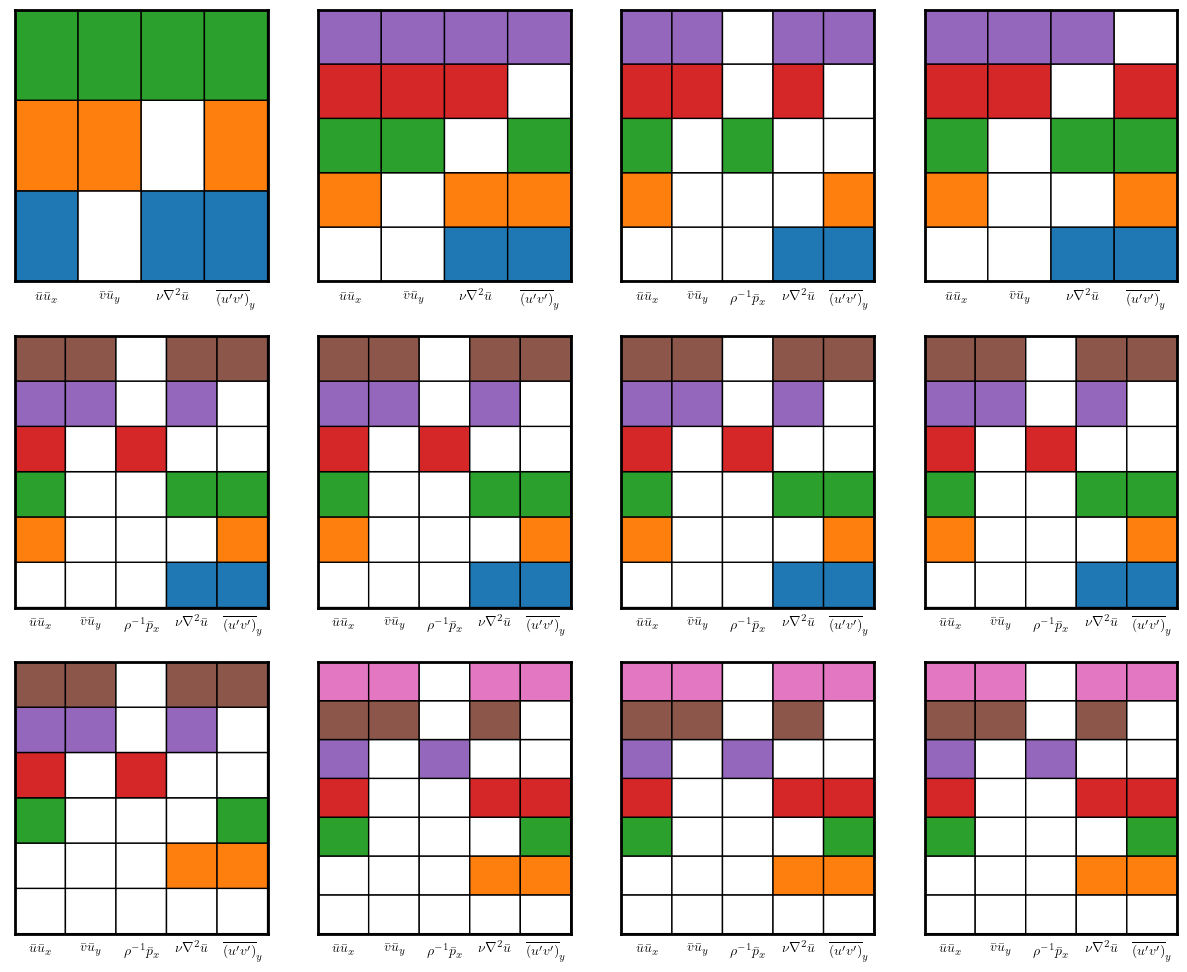

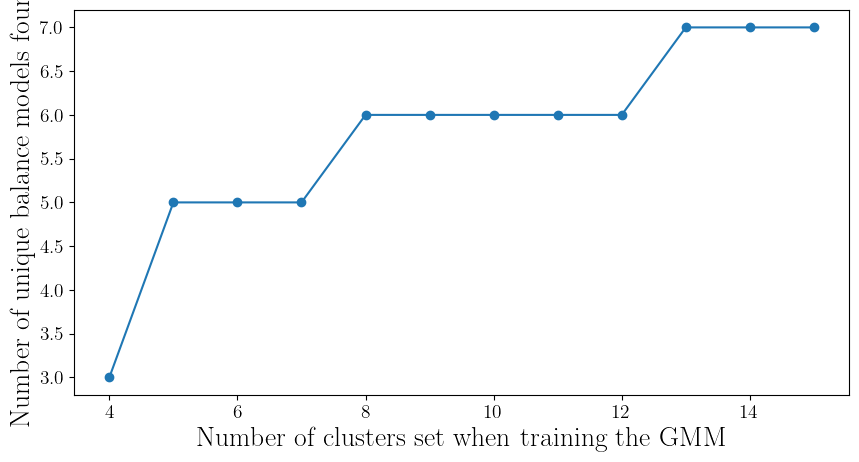

In [38]:
# Initialise a list of the number of dominant balance models found
nmodels_list = []

# Define a list of number of clusters to set
n_clusters = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
np.random.seed(75016)

# Plot all found dominant balance regimes for each initial cluster number
plt.figure(figsize=(15, 12))
for n_cluster in n_clusters:
    # Get clusters for the current number of clusters
    cluster_idx = sa.get_clusters(n_cluster, features, 0.1)

    alpha_opt = 10  # Optimal alpha value, in all cases the optimal alpha is 10
    spca_model = sa.get_spca_active_terms(
        alpha_opt, n_cluster, cluster_idx, features, nfeatures
    )

    (
        balance_models,
        model_index,
        nmodels,
        gridmap,
        grid_labels,
    ) = sa.get_unique_balance_models(spca_model)

    nmodels_list.append(nmodels)

    plt.subplot(3, 4, n_cluster - 3)
    plt.pcolor(
        gridmap, vmin=-0.5, vmax=cm.N - 0.5, cmap=cm, edgecolors="k", linewidth=1
    )
    plt.gca().set_xticks(np.arange(0.5, len(grid_labels) + 0.5))
    plt.gca().set_xticklabels(grid_labels, fontsize=10)
    plt.gca().set_yticklabels([])

    for axis in ["top", "bottom", "left", "right"]:
        plt.gca().spines[axis].set_linewidth(2)

    plt.gca().tick_params(axis="both", width=0)

plot_dir = os.path.join(plots_dir, "different_cluster_numbers_bal_mods.png")
plt.savefig(plot_dir, bbox_inches="tight")

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(n_clusters, nmodels_list, "o-")
plt.xlabel("Number of clusters set when training the GMM")
plt.ylabel("Number of unique balance models found")
plot_dir = os.path.join(plots_dir, "different_cluster_numbers_nmodels.png")
plt.savefig(plot_dir, bbox_inches="tight")

plt.show()

In [39]:
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

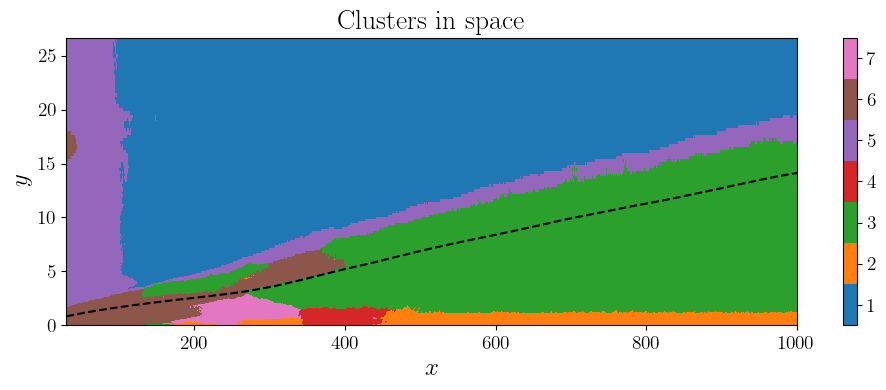

In [40]:
pf.plot_clustering_space(
    balancemap,
    x,
    y,
    X,
    Y,
    nx,
    ny,
    nmodels,
    u_bar,
    U_inf,
    "Stab_Ass/spca_clustering_space.png",
)

## B. Under different training set sizes

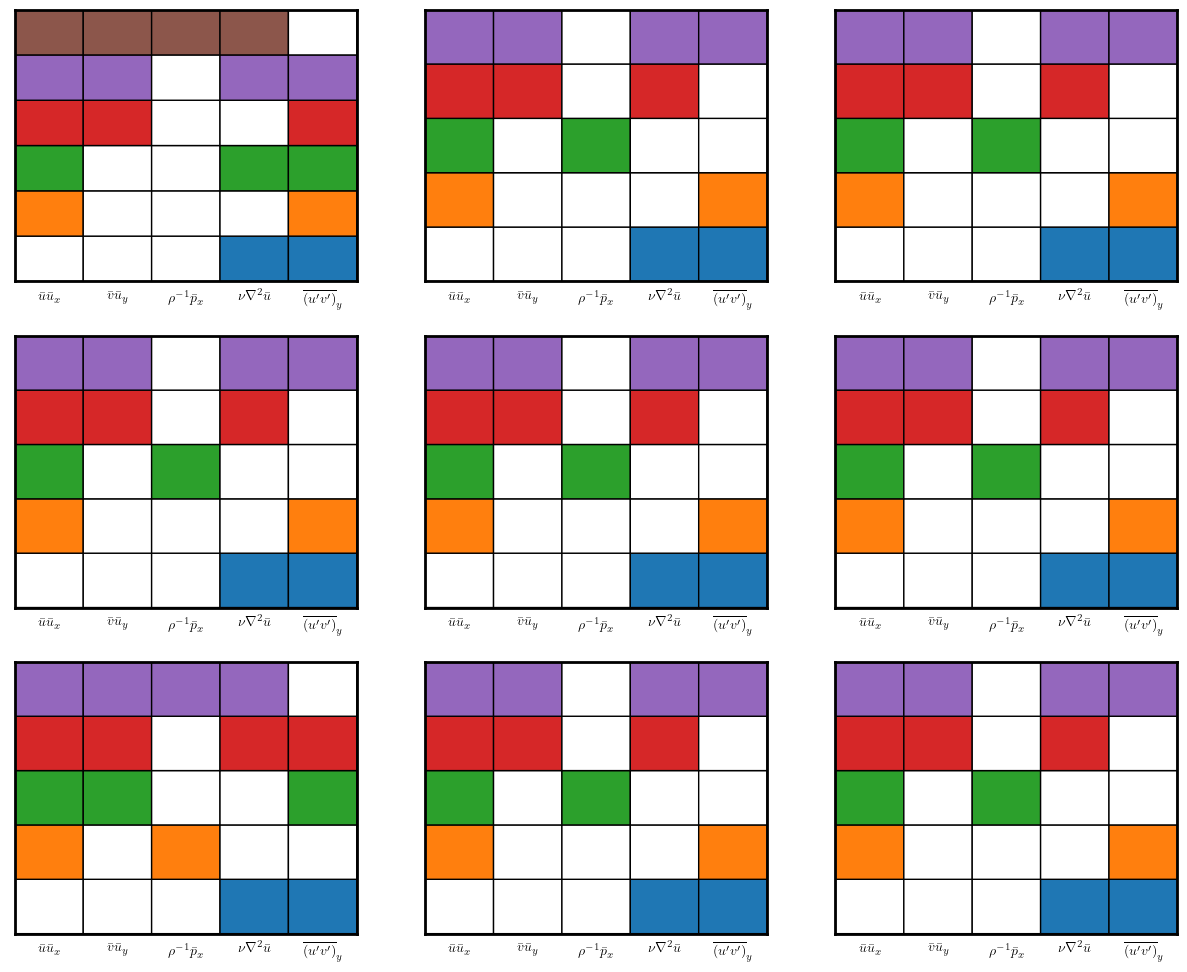

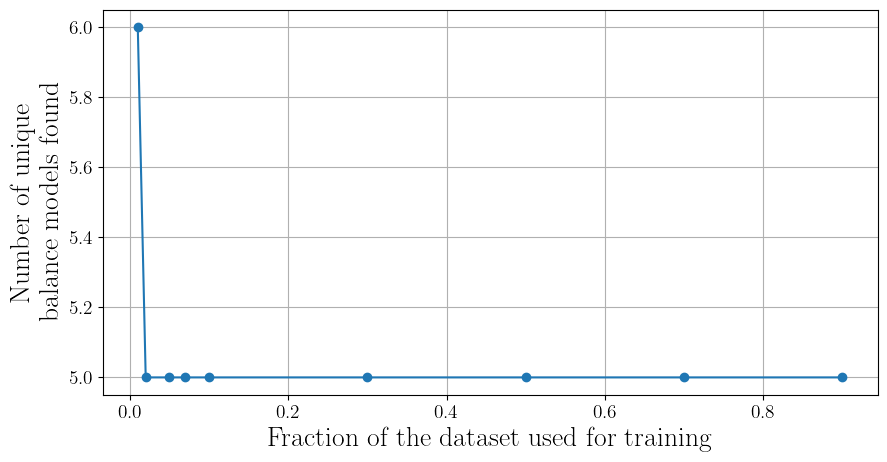

In [41]:
# Initialise a list of the number of dominant balance models found
nmodels_list = []

# Define a list of training set sizes, as fractions of the total dataset
train_frac = [0.01, 0.02, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 0.9]

# Plot all found dominant balance regimes for each initial cluster number
plt.figure(figsize=(15, 12))
for idx, frac in enumerate(train_frac):
    # Get clusters for the current number of clusters
    cluster_idx = sa.get_clusters(n_clusters=6, features=features, train_frac=frac)

    alpha_opt = 10  # Optimal alpha value, in all cases the optimal alpha is 10
    spca_model = sa.get_spca_active_terms(
        alpha_opt, 6, cluster_idx, features, nfeatures
    )

    (
        balance_models,
        model_index,
        nmodels,
        gridmap,
        grid_labels,
    ) = sa.get_unique_balance_models(spca_model)

    nmodels_list.append(nmodels)

    plt.subplot(3, 3, idx + 1)
    plt.pcolor(
        gridmap, vmin=-0.5, vmax=cm.N - 0.5, cmap=cm, edgecolors="k", linewidth=1
    )
    plt.gca().set_xticks(np.arange(0.5, len(grid_labels) + 0.5))
    plt.gca().set_xticklabels(grid_labels, fontsize=10)
    plt.gca().set_yticklabels([])

    for axis in ["top", "bottom", "left", "right"]:
        plt.gca().spines[axis].set_linewidth(2)

    plt.gca().tick_params(axis="both", width=0)

plot_dir = os.path.join(plots_dir, "different_train_frac_bal_mods.png")
plt.savefig(plot_dir, bbox_inches="tight")

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_frac, nmodels_list, "o-")
plt.xlabel("Fraction of the dataset used for training")
plt.ylabel("Number of unique \n balance models found")
plt.grid()

plot_dir = os.path.join(plots_dir, "different_train_frac_nmodels.png")
plt.savefig(plot_dir, bbox_inches="tight")

plt.show()

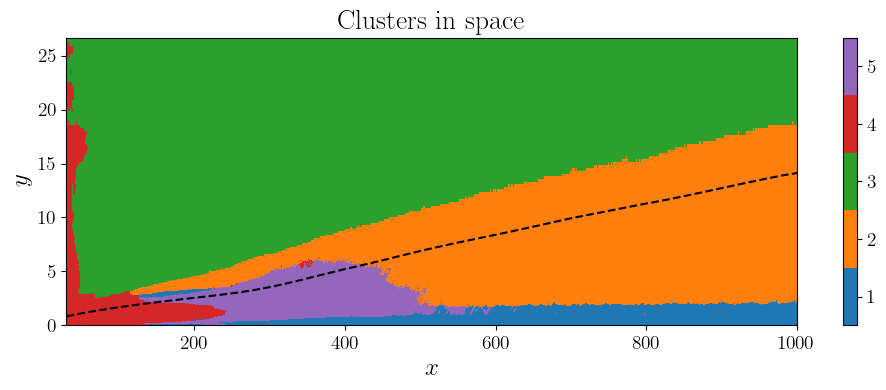

In [42]:
# Get clusters for training set size: 0.5
cluster_idx = sa.get_clusters(n_clusters=6, features=features, train_frac=0.9)

alpha_opt = 10  # Optimal alpha value, in all cases the optimal alpha is 10
spca_model = sa.get_spca_active_terms(alpha_opt, 6, cluster_idx, features, nfeatures)

(
    balance_models,
    model_index,
    nmodels,
    gridmap,
    grid_labels,
) = sa.get_unique_balance_models(spca_model)

balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

pf.plot_clustering_space(
    balancemap,
    x,
    y,
    X,
    Y,
    nx,
    ny,
    nmodels,
    u_bar,
    U_inf,
    "Stab_Ass/spca_clustering_space_train_frac.png",
)

# C. Under different alpha values

/Users/thomasbreitburd/anaconda3/envs/Project_24/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


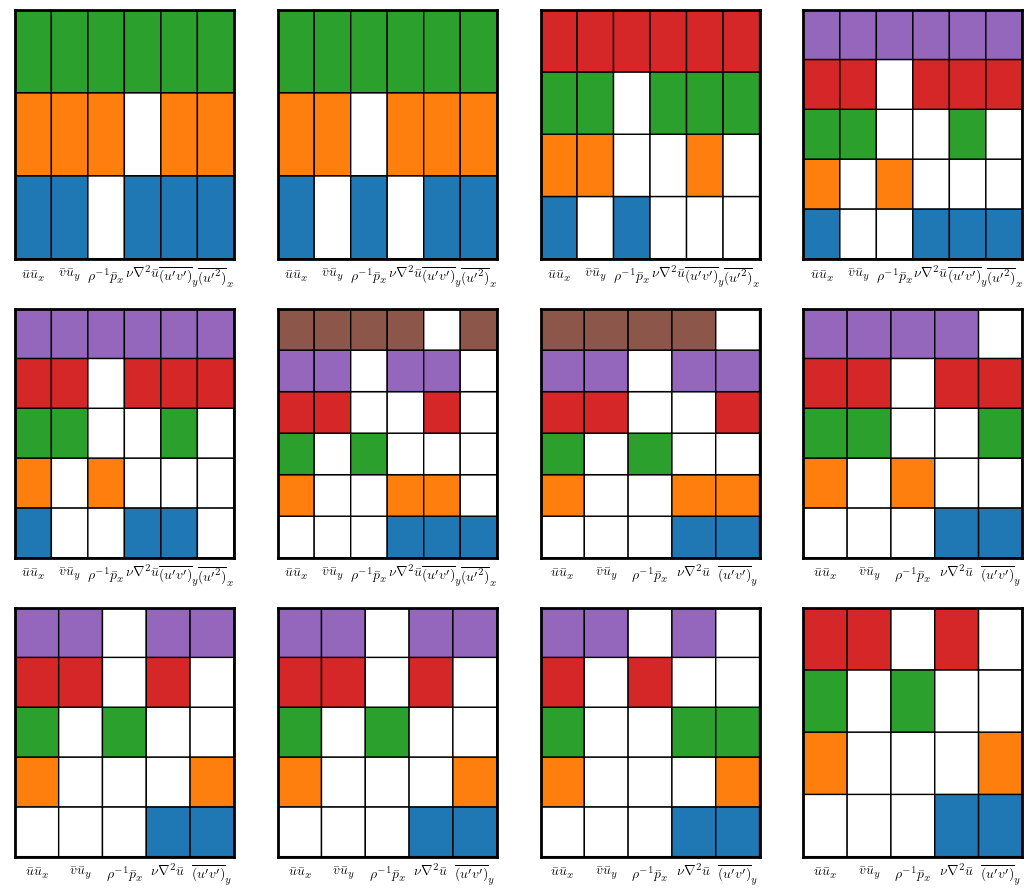

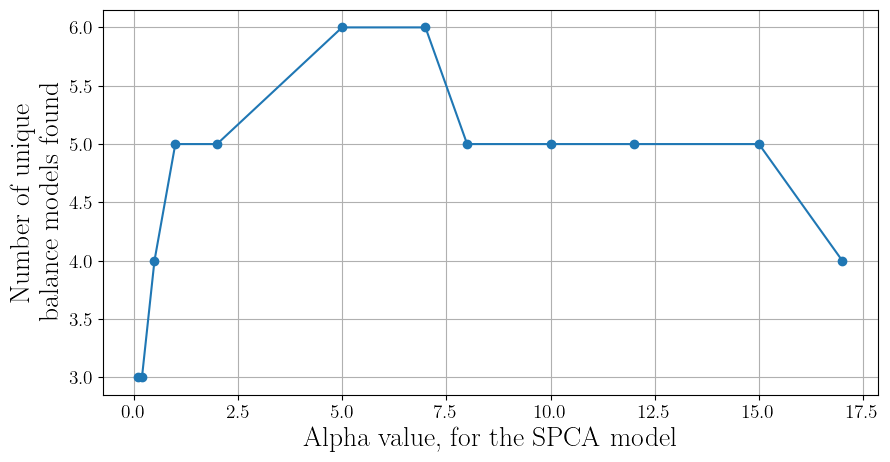

In [43]:
# Initialise a list of the number of dominant balance models found
nmodels_list = []

# Define a list of training set sizes, as fractions of the total dataset
alphas = [0.1, 0.2, 0.5, 1, 2, 5, 7, 8, 10, 12, 15, 17]

# Plot all found dominant balance regimes for each initial cluster number
plt.figure(figsize=(13, 11))

# Get clusters with GMM
cluster_idx = sa.get_clusters(n_clusters=6, features=features, train_frac=0.1)

for idx, alpha in enumerate(alphas):
    # Get the active terms for the current alpha
    spca_model = sa.get_spca_active_terms(alpha, 6, cluster_idx, features, nfeatures)

    (
        balance_models,
        model_index,
        nmodels,
        gridmap,
        grid_labels,
    ) = sa.get_unique_balance_models(spca_model)

    nmodels_list.append(nmodels)

    plt.subplot(3, 4, idx + 1)
    plt.pcolor(
        gridmap, vmin=-0.5, vmax=cm.N - 0.5, cmap=cm, edgecolors="k", linewidth=1
    )
    plt.gca().set_xticks(np.arange(0.5, len(grid_labels) + 0.5))
    plt.gca().set_xticklabels(grid_labels, fontsize=10)
    plt.gca().set_yticklabels([])

    for axis in ["top", "bottom", "left", "right"]:
        plt.gca().spines[axis].set_linewidth(2)

    plt.gca().tick_params(axis="both", width=0)

plot_dir = os.path.join(plots_dir, "different_alpha_bal_mods.png")
plt.savefig(plot_dir, bbox_inches="tight")

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(alphas, nmodels_list, "o-")
plt.xlabel("Alpha value, for the SPCA model")
plt.ylabel("Number of unique \n balance models found")
plt.grid()

plot_dir = os.path.join(plots_dir, "different_alpha_nmodels.png")
plt.savefig(plot_dir, bbox_inches="tight")

plt.show()